### Data Analysis & Feature Engineering

This notebook is the main work focusing on data exploration and factors design.

The research mainly focused on 4 types of factors:
+ Negative Converting Premium Arbitrage
+ Momentum of Overnight Return
+ Mean Reversion of Overvalue - based on Pricing Model 
+ Mean Reversion of Intraday Return

In [1]:
import os
import copy
import talib
import pickle
import random
import numpy as np
import pandas as pd
import scipy.stats as st 
import import_ipynb
import statsmodels.api as sm
from tqdm import tqdm, trange
import seaborn as sns
from matplotlib import pyplot as plt 

plt.style.use('seaborn')
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#### Data Loading

In [2]:
data_path = '../../../../export/scratch/for_yifan/research/'
cbond_info = pd.read_csv(os.path.join(data_path, 'cbond_info.csv'), index_col=False, low_memory=False)
cbond_price = pd.read_csv(os.path.join(data_path, 'cbond_price.csv'), index_col=False, low_memory=False)
stock_df = pd.read_csv(os.path.join(data_path, 'stock_price.csv'), index_col=False, low_memory=False)

In [3]:
cbond_info.head(1)

,bond_ticker,stock_ticker,name,listed_date,start_date,exit_date,conv_date,conv_price,rdmpt_bgndt,rdmpt_enddt,rdmpt_transit,rpchs_bgndt,rpchs_enddt,rpchs_transit,term_year,interest_freq,payment,put_win,put_price,call_win,call_min,call_price
0,110030.SH,600185.SH,格力地产,20150113,20170103,20191210,20141223,20.9000,20150630,20191224,130.0000,20161225.0000,20191225.0000,70.0000,5.0000,1,106.0000,30,103,30,15,100


In [4]:
cbond_price.head(1)

,bond_ticker,date,open,high,low,close,volume,amount,pre_close,ovnt_ret,intra_ret,return,next_return,is_last,conv_price,rdmpt_bgndt,rdmpt_enddt,stock_ticker,adj_factor,top1500,adj_conv_price,adj_conv_share
0,110030.SH,20170103,113.8000,114.1500,113.8000,114.0400,3650.0000,4163.4180,NaN,NaN,0.0021,NaN,0.0017,False,7.2600,20150630,20191224,600185.SH,0.1652,False,43.9513,2.2752


In [5]:
stock_df.head(1)

,BloombergID,stock_ticker,date,adj_close,adj_open,adj_pre_close,adj_factor,vol100,vol250,value,mkt,top1500,CSI300,CSI800,limit_buy_open,limit_sell_open,limit_buy_close,limit_sell_close,is_unusual
0,EQ0000000025800901,600959.SH,20170103,14.7744,14.7351,14.8006,0.7635,0.0106,0.0106,151838808.4200,43934032026.6900,True,True,True,False,False,False,False,False


### 1. Arbitrage Strategy - Negative Converting Premium

In [6]:
# find negative premium opportunities
cbond_data = pd.merge(left=cbond_price, 
                       right=stock_df[['stock_ticker', 'date', 'adj_open', 'adj_close', 'value', 'mkt',
                                       'CSI300', 'CSI800', 'limit_sell_close', 'is_unusual']], 
                      on=['stock_ticker', 'date'], how='left')

cbond_data['conv_open'] = cbond_data['adj_open'] * cbond_data['adj_conv_share']
cbond_data['conv_close'] = cbond_data['adj_close'] * cbond_data['adj_conv_share']
cbond_data['premium_close'] = cbond_data['close'] / cbond_data['conv_close'] - 1
cbond_data['premium_open'] = cbond_data['open'] / cbond_data['conv_open'] - 1
cbond_data['neg_premium'] = cbond_data['premium_close'].map(lambda x: x < 0)

cond_1 = (cbond_data['is_last']==False)
cond_2 = (cbond_data['rdmpt_bgndt'] <= cbond_data['date'])
cond_3 = (cbond_data['rdmpt_enddt'] >= cbond_data['date'])

cbond_data['is_valid'] = (cond_1 & cond_2 & cond_3)

cbond_data = cbond_data[cbond_data['is_valid']==True].reset_index(drop=True)

cbond_data['date'] = cbond_data['date'].astype('str')
cbond_data['datetime'] = pd.to_datetime(cbond_data['date'])
cbond_data['year'] = cbond_data['datetime'].map(lambda x: x.year)

cbond_data = cbond_data[['date', 'bond_ticker', 'stock_ticker', 'premium_close', 'neg_premium',
                           'limit_sell_close', 'is_unusual', 'top1500', 'CSI300', 'CSI800', 'mkt', 'amount', 'value', 'year']].copy()
cbond_data.head()

,date,bond_ticker,stock_ticker,premium_close,neg_premium,limit_sell_close,is_unusual,top1500,CSI300,CSI800,mkt,amount,value,year
0,20170103,110030.SH,600185.SH,0.4153,False,False,False,False,False,False,12020099994.1650,4163.4180,25328684.7000,2017
1,20170103,110031.SH,600271.SH,1.2852,False,False,False,False,True,True,37397922324.7500,8258.4090,274287525.7500,2017
2,20170103,110032.SH,600031.SH,0.3358,False,False,False,False,True,True,46959012659.9900,31948.0030,113340049.4600,2017
3,20170103,110033.SH,600755.SH,0.2274,False,False,False,True,False,True,13815329499.0000,3513.5940,127285073.3000,2017
4,20170103,110034.SH,600998.SH,0.0908,False,False,False,False,False,False,34587519960.0000,13703.6730,124275480.0000,2017


In [7]:
# samples distribution in different years
cbond_data['year'].value_counts()

2019    27181
2020    25969
2018    10000
2017     3270
Name: year, dtype: int64

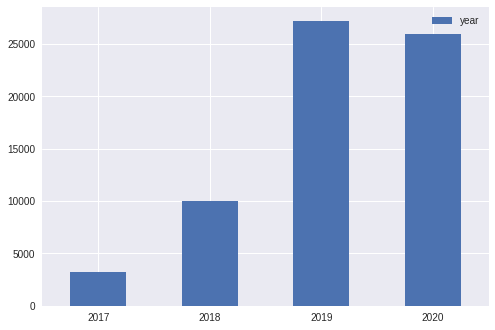

In [8]:
fig = cbond_data['year'].value_counts().to_frame().sort_index().plot.bar(rot=0)

负溢价样本的转债日均交易额，股票收益率和市值都偏大

In [9]:
cbond_data[['mkt', 'amount', 'value']].mean()

mkt      19493124869.6932
amount         70261.7547
value      208155469.9044
dtype: float64

In [10]:
cbond_data.loc[cbond_data['premium_close'] < 0, ['mkt', 'amount', 'value']].mean()

mkt      26375279620.7247
amount        230533.2996
value      602206849.0367
dtype: float64

In [11]:
# coverage ratio of each index 
cbond_data[['top1500', 'CSI300', 'CSI800']].mean()

top1500   0.4784
CSI300    0.1765
CSI800    0.3761
dtype: float64

In [12]:
# save as csv
cbond_data.to_csv(os.path.join(data_path, 'neg_premium.csv'), index=False)

### 2. Ovnt Strategy

In [13]:
def linearAnalysis(data, x, y, group_num=10):
    """
    visualize linear relationship between columns x and y in data using bar plot and linear regression plot
    """
    tmp = data[[x, y]].copy()
    tmp = tmp.dropna()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # group analysis
    tmp['group'] = pd.qcut(tmp[x], 
                           np.linspace(0, 1, group_num + 1), [str(i + 1) for i in range(group_num)])
    
    group = tmp.groupby('group')[y].mean().to_frame()
    fig = group.plot.bar(ax=ax1, title='{} group mean by {}'.format(y, x), rot=0)
    
    # regression
    x_val = tmp[x].values
    y_val = tmp[y].values
    x_val = sm.add_constant(x_val)
    model = sm.OLS(y_val, x_val)
    results = model.fit()
    
    fig = sns.regplot(x=x, y=y, data=tmp, ax=ax2, scatter_kws={'alpha': 0.3})
    ax2.set_title('{} ~ {} \n \n beta: {}   R2: {}'.format(y,x, np.round(results.params[1], 4),
                                                           np.round(results.rsquared, 4)))
    plt.show()

In [14]:
# feature engineering
cbond_data = pd.merge(left=cbond_price, 
                       right=stock_df[['stock_ticker', 'date', 'adj_open', 'adj_close', 'adj_pre_close', 'value', 'mkt',
                                      'CSI300', 'CSI800']], on=['stock_ticker', 'date'], how='left')

cbond_data = cbond_data.sort_values(by=['date', 'bond_ticker'])

cbond_data['amount'] = cbond_data['amount'] / 1e5
cbond_data['value'] = cbond_data['value'] / 1e8
cbond_data['mkt'] = cbond_data['mkt'] / 1e8
cbond_data['bond_weight'] = cbond_data.groupby('date').apply(lambda g: g['amount'] / g['amount'].sum()).values
cbond_data['stock_weight'] = cbond_data.groupby('date').apply(lambda g: g['value'] / g['value'].sum()).values

cbond_data = cbond_data.sort_values(by=['bond_ticker', 'date'])

# negative premium
cbond_data['conv_open'] = cbond_data['adj_open'] * cbond_data['adj_conv_share']
cbond_data['conv_close'] = cbond_data['adj_close'] * cbond_data['adj_conv_share']
cbond_data['premium_close'] = cbond_data['close'] / cbond_data['conv_close'] - 1
cbond_data['premium_open'] = cbond_data['open'] / cbond_data['conv_open'] - 1

thr = 0.001

cond_1 = (cbond_data['premium_close'] < - thr)
cond_2 = (cbond_data['is_last']==False)
cond_3 = (cbond_data['rdmpt_bgndt'] <= cbond_data['date'])
cond_4 = (cbond_data['rdmpt_enddt'] >= cbond_data['date'])

cbond_data['neg_premium'] = (cond_1 & cond_2 & cond_3 & cond_4)

cbond_data.rename(columns={'adj_open': 'stock_open', 'adj_close': 'stock_close', 'adj_pre_close': 'stock_pre_close'}, inplace=True)

# calculate return
cbond_data['stock_ovnt_ret'] = cbond_data['stock_open'] / cbond_data['stock_pre_close'] - 1
cbond_data['stock_intra_ret'] = cbond_data['stock_close'] / cbond_data['stock_open'] - 1
cbond_data['stock_ret'] = cbond_data['stock_close'] / cbond_data['stock_pre_close'] - 1
cbond_data = cbond_data[['date', 'bond_ticker', 'stock_ticker', 'high', 'low', 'open', 'close', 'volume', 
                         'ovnt_ret', 'intra_ret', 'return', 'premium_open', 'premium_close', 'neg_premium',
                         'amount', 'value', 'mkt', 'bond_weight', 'stock_weight', 'stock_ovnt_ret', 'stock_intra_ret', 'stock_ret', 'is_last', 
                         'top1500', 'CSI300', 'CSI800']].copy()

cbond_data['ret'] = cbond_data['return']
cbond_data['abs_ret'] = cbond_data['ret'].abs()
cbond_data['abs_ovnt_ret'] = cbond_data['ovnt_ret'].abs()
cbond_data['abs_intra_ret'] = cbond_data['intra_ret'].abs()
cbond_data['abs_stock_ret'] = cbond_data['stock_ret'].abs()

cbond_data['next_ret'] = cbond_data.groupby('bond_ticker')['ret'].shift(-1)
cbond_data['next_ovnt_ret'] = cbond_data.groupby('bond_ticker')['ovnt_ret'].shift(-1)
cbond_data['next_intra_ret'] = cbond_data.groupby('bond_ticker')['intra_ret'].shift(-1)

# consecutive limit up
up_limit = 0.095

ret_0 = cbond_data['stock_ret']
ret_1 = cbond_data.groupby('stock_ticker')['stock_ret'].shift(1)
ret_2 = cbond_data.groupby('stock_ticker')['stock_ret'].shift(2)
ret_3 = cbond_data.groupby('stock_ticker')['stock_ret'].shift(3)
ret_4 = cbond_data.groupby('stock_ticker')['stock_ret'].shift(4)

cbond_data['up_1'] = (ret_0 > up_limit) * 1
cbond_data['up_2'] = cbond_data['up_1'] * (ret_1 > up_limit)
cbond_data['up_3'] = cbond_data['up_2'] * (ret_2 > up_limit)
cbond_data['up_4'] = cbond_data['up_3'] * (ret_3 > up_limit)
cbond_data['up'] = cbond_data['up_1'] + cbond_data['up_2'] + cbond_data['up_3'] + cbond_data['up_4']
cbond_data['up_bool'] = cbond_data['up'].astype('bool')
cbond_data.drop(columns=['up_1', 'up_2', 'up_3', 'up_4'], inplace=True)

cbond_data['date'] = cbond_data['date'].astype('str')
cbond_data['datetime'] = pd.to_datetime(cbond_data['date'])
cbond_data['year'] = cbond_data['datetime'].map(lambda x: x.year)

cbond_data.dropna(inplace=True)  # drop(97518-97161=357) nan samples
cbond_data = cbond_data[cbond_data['is_last']==False].reset_index(drop=True)  # drop last trading day sample

# TAlib indicator
cbond_data['atr'] = cbond_data.groupby('bond_ticker').apply(
    lambda x: talib.ATR(x['high'], x['low'], x['close'], timeperiod=5) / x['close']).fillna(0).values
# cbond_data['adx10'] = cbond_data.groupby('bond_ticker').apply(
#     lambda x: talib.ADX(x['high'], x['low'], x['close'], timeperiod=10)).fillna(0).values
# cbond_data['apo5_10'] = cbond_data.groupby('bond_ticker')['close'].apply(
#     talib.APO, fastperiod=5, slowperiod=10, matype=0).fillna(0).values
# cbond_data['apo1_5'] = cbond_data.groupby('bond_ticker')['close'].apply(
#     talib.APO, fastperiod=2, slowperiod=5, matype=0).fillna(0).values
# cbond_data['obv'] = cbond_data.groupby('bond_ticker').apply(
#     lambda x: talib.OBV(x['close'], x['volume'])).fillna(0).values
# cbond_data['ad'] = cbond_data.groupby('bond_ticker').apply(
#     lambda x: talib.AD(x['high'], x['low'], x['close'], x['volume'])).fillna(0).values
# cbond_data['adosc'] = cbond_data.groupby('bond_ticker').apply(
#     lambda x: talib.ADOSC(x['high'], x['low'], x['close'], x['volume'], fastperiod=3, slowperiod=10)).fillna(0).values
# cbond_data['rsi'] = cbond_data.groupby('bond_ticker')['close'].apply(
#     talib.RSI, timeperiod=10).fillna(0).values

cbond_data.head()

,date,bond_ticker,stock_ticker,high,low,open,close,volume,ovnt_ret,intra_ret,return,premium_open,premium_close,neg_premium,amount,value,mkt,bond_weight,stock_weight,stock_ovnt_ret,stock_intra_ret,stock_ret,is_last,top1500,CSI300,CSI800,ret,abs_ret,abs_ovnt_ret,abs_intra_ret,abs_stock_ret,next_ret,next_ovnt_ret,next_intra_ret,up,up_bool,datetime,year,atr
0,20170104,110030.SH,600185.SH,114.3500,113.9500,114.0000,114.2300,1201.0000,-0.0004,0.0020,0.0017,0.4172,0.4032,False,0.0137,0.3096,121.2310,0.0065,0.0195,-0.0017,0.0120,0.0103,False,False,False,False,0.0017,0.0017,0.0004,0.0020,0.0103,0.0063,0.0052,0.0011,0,False,2017-01-04,2017,0.0000
1,20170105,110030.SH,600185.SH,115.5000,114.3600,114.8200,114.9500,9999.0000,0.0052,0.0011,0.0063,0.3688,0.4026,False,0.1152,0.5564,123.9090,0.0287,0.0325,0.0305,-0.0230,0.0068,False,False,False,False,0.0063,0.0063,0.0052,0.0011,0.0068,-0.0008,-0.0030,0.0023,0,False,2017-01-05,2017,0.0000
2,20170106,110030.SH,600185.SH,115.1500,114.6000,114.6000,114.8600,4822.0000,-0.0030,0.0023,-0.0008,0.4007,0.4134,False,0.0554,0.2191,122.0550,0.0334,0.0170,-0.0017,-0.0067,-0.0084,False,False,False,False,-0.0008,0.0008,0.0030,0.0023,0.0084,0.0058,0.0000,0.0058,0,False,2017-01-06,2017,0.0000
3,20170109,110030.SH,600185.SH,115.5300,114.3000,114.8600,115.5300,3337.0000,0.0000,0.0058,0.0058,0.4158,0.4264,False,0.0383,0.3664,121.2310,0.0127,0.0189,-0.0017,-0.0017,-0.0034,False,False,False,False,0.0058,0.0058,0.0000,0.0058,0.0034,-0.0033,0.0028,-0.0060,0,False,2017-01-09,2017,0.0000
4,20170110,110030.SH,600185.SH,115.9000,115.1000,115.8500,115.1500,500.0000,0.0028,-0.0060,-0.0033,0.4304,0.4193,False,0.0058,0.2184,121.1280,0.0017,0.0184,0.0000,0.0017,0.0017,False,False,False,False,-0.0033,0.0033,0.0028,0.0060,0.0017,-0.0046,0.0022,-0.0068,0,False,2017-01-10,2017,0.0000


In [15]:
cbond_data['atr'].describe()

count   97161.0000
mean        0.0225
std         0.0230
min         0.0000
25%         0.0097
50%         0.0159
75%         0.0267
max         0.4723
Name: atr, dtype: float64

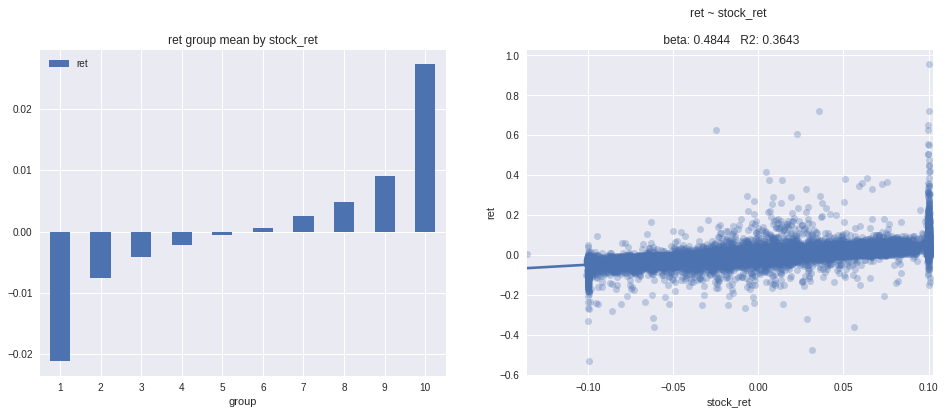

In [16]:
linearAnalysis(data=cbond_data, x='stock_ret', y='ret')

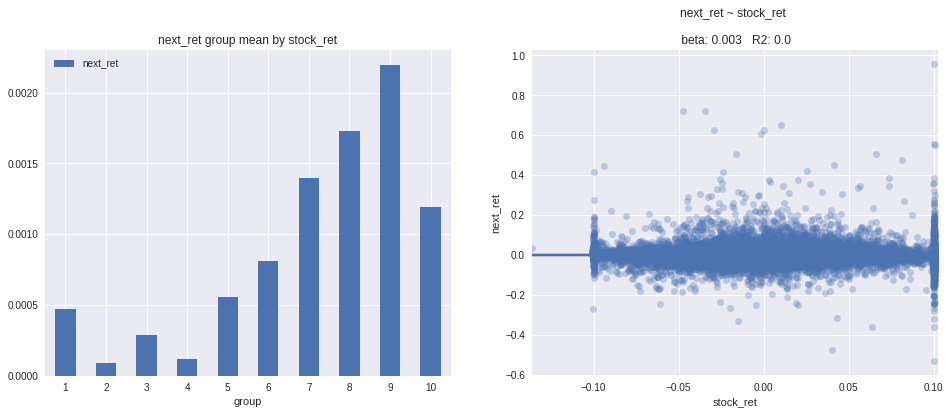

In [17]:
linearAnalysis(data=cbond_data, x='stock_ret', y='next_ret')

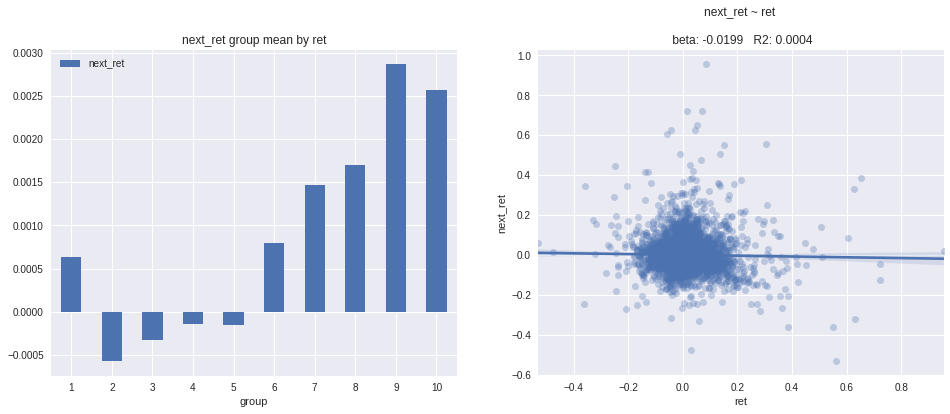

In [18]:
linearAnalysis(data=cbond_data, x='ret', y='next_ret')

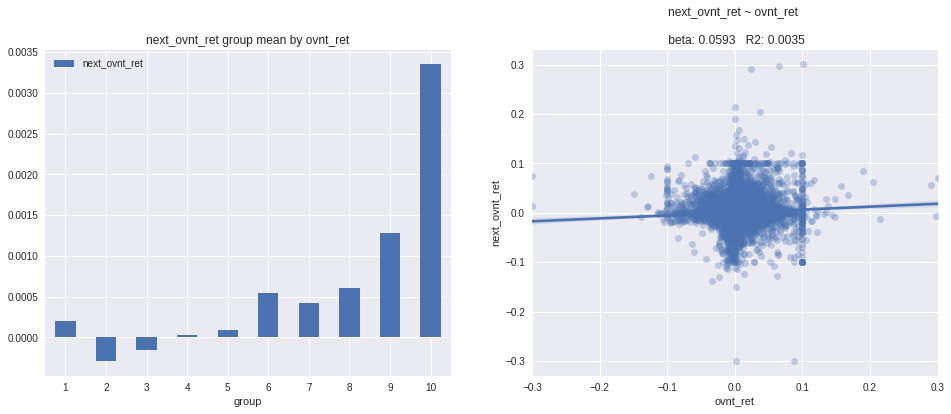

In [19]:
linearAnalysis(data=cbond_data, x='ovnt_ret', y='next_ovnt_ret')

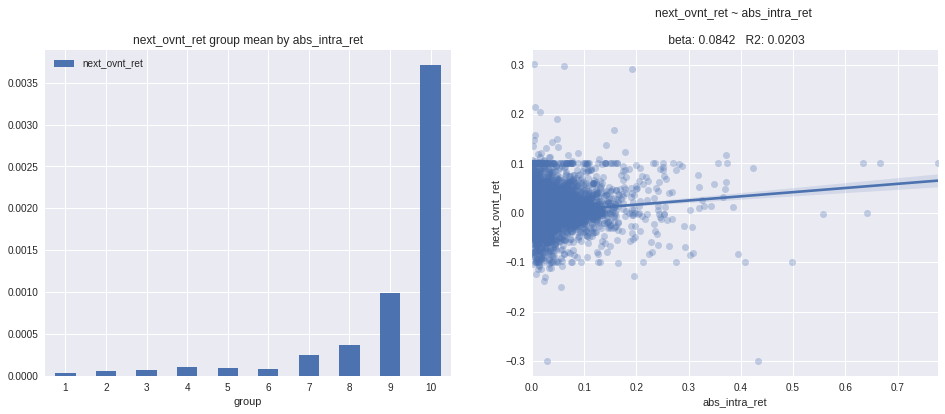

In [20]:
linearAnalysis(data=cbond_data, x='abs_intra_ret', y='next_ovnt_ret')

Note: 10% limit up for the open price of convertible bond

In [21]:
cbond_data['score'] = cbond_data['abs_intra_ret'] + cbond_data['ovnt_ret']

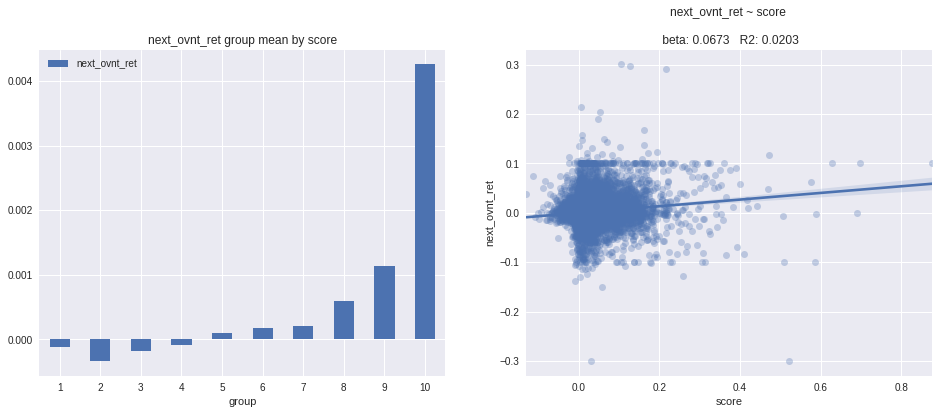

In [22]:
linearAnalysis(data=cbond_data, x='score', y='next_ovnt_ret')

In [23]:
# limit up statistics
up_dict = {'up':[],
           'sample':[],
           'pct':[],
          }
          
des_data = []

for i in range(5): 
    tmp = cbond_data.loc[cbond_data['up']==i].copy()
    pct = len(tmp[tmp['next_ovnt_ret'] > 0.01]) / len(tmp)
    up_dict['up'].append(i)
    up_dict['sample'].append(len(tmp))
    up_dict['pct'].append(pct)
    
    des = tmp['next_ovnt_ret'].describe().to_frame()
    des.columns = ['up_{}'.format(i)]
    des_data.append(des)
    
display(pd.DataFrame(up_dict))
display(pd.concat(des_data, axis=1))

,up,sample,pct
0,0,95905,0.0586
1,1,1031,0.2726
2,2,143,0.2937
3,3,49,0.4082
4,4,33,0.5152


,up_0,up_1,up_2,up_3,up_4
count,95905.0000,1031.0000,143.0000,49.0000,33.0000
mean,0.0005,0.0052,0.0023,0.0040,0.0117
std,0.0095,0.0279,0.0470,0.0366,0.0720
min,-0.3000,-0.1019,-0.1277,-0.1000,-0.3000
25%,-0.0017,-0.0048,-0.0154,-0.0122,-0.0020
50%,0.0000,0.0009,-0.0012,0.0004,0.0160
75%,0.0016,0.0119,0.0138,0.0200,0.0369
max,0.2969,0.3004,0.2902,0.1000,0.1678


#### CBond-Stock Spread

In [24]:
# calculate cbond stock spread
cbond_data = cbond_data.sort_values(by=['bond_ticker', 'date'])

lag_cols = ['ovnt_ret', 'ret', 'abs_ret', 'abs_intra_ret', 
            'stock_ovnt_ret', 'premium_close', 'premium_open']
wins = [3, 5, 10, 30, 60]

for win in wins:
    for col in lag_cols:
        cbond_data['{}{}'.format(col, win)] = cbond_data.groupby('bond_ticker').apply(lambda g: g[col].rolling(win, min_periods=1).mean()).values
    
    # use 2017-2019 data to estimate beta
    x_val = cbond_data.loc[cbond_data['date']<='20191231', 'stock_ovnt_ret{}'.format(win)].values
    y_val = cbond_data.loc[cbond_data['date']<='20191231','ovnt_ret{}'.format(win)].values
    x_val = sm.add_constant(x_val)
    model = sm.OLS(y_val, x_val)
    results = model.fit()

    beta = results.params[1]
    cbond_data['spread{}'.format(win)] = cbond_data['ovnt_ret{}'.format(win)] - cbond_data['stock_ovnt_ret{}'.format(win)] * beta

In [25]:
# top 10 highest next_ovnt_ret correlation with other features
cbond_data.corr()['next_ovnt_ret'].sort_values(ascending=False).iloc[2:12]

atr               0.2142
abs_ret5          0.1922
abs_ret10         0.1885
abs_ret3          0.1858
abs_intra_ret5    0.1856
abs_intra_ret10   0.1841
abs_intra_ret3    0.1800
abs_ret30         0.1720
spread30          0.1708
abs_intra_ret30   0.1669
Name: next_ovnt_ret, dtype: float64

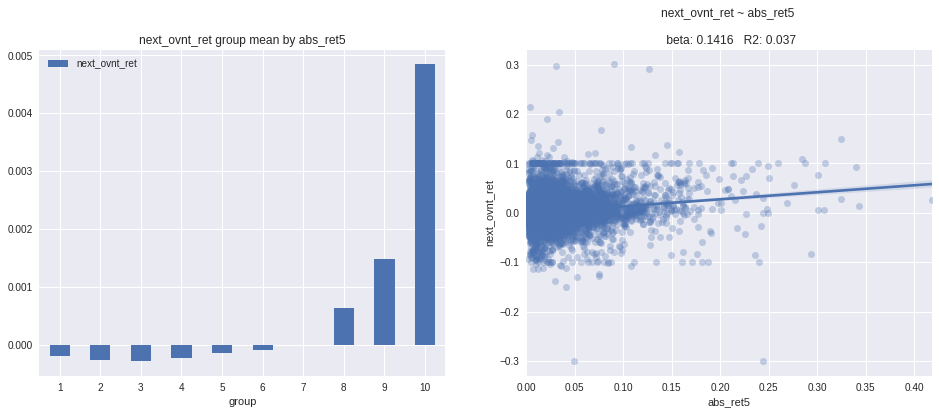

In [26]:
linearAnalysis(cbond_data, 'abs_ret5'.format(win), 'next_ovnt_ret')

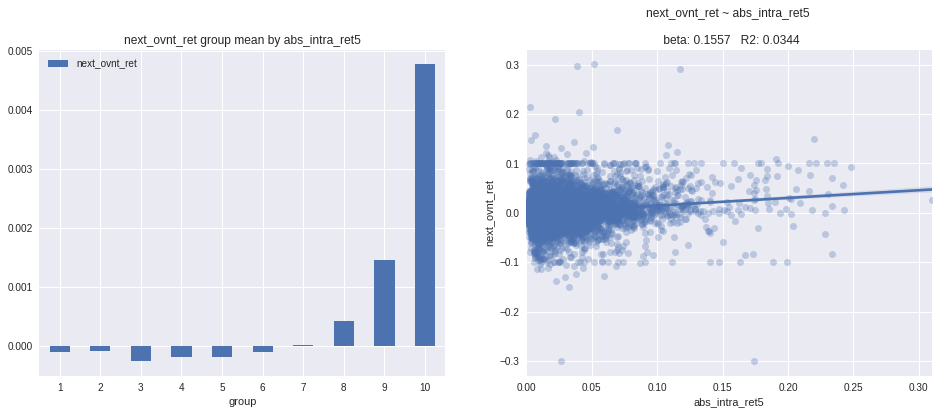

In [27]:
linearAnalysis(cbond_data, 'abs_intra_ret5'.format(win), 'next_ovnt_ret')

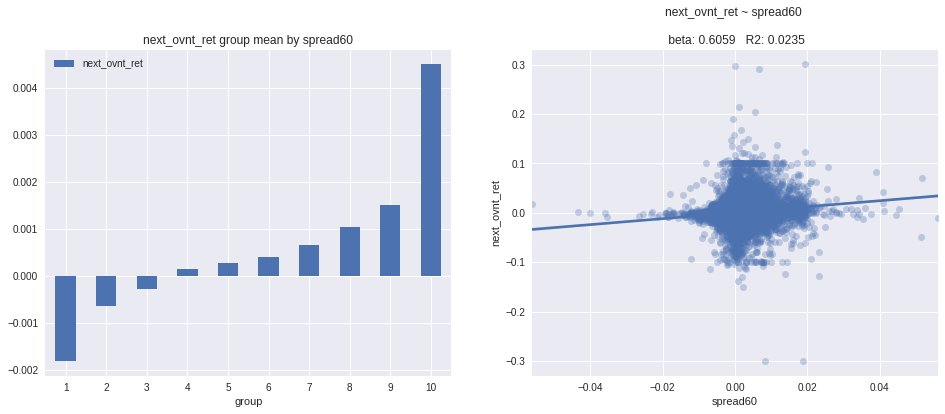

In [28]:
win = 60
linearAnalysis(cbond_data, 'spread{}'.format(win), 'next_ovnt_ret')

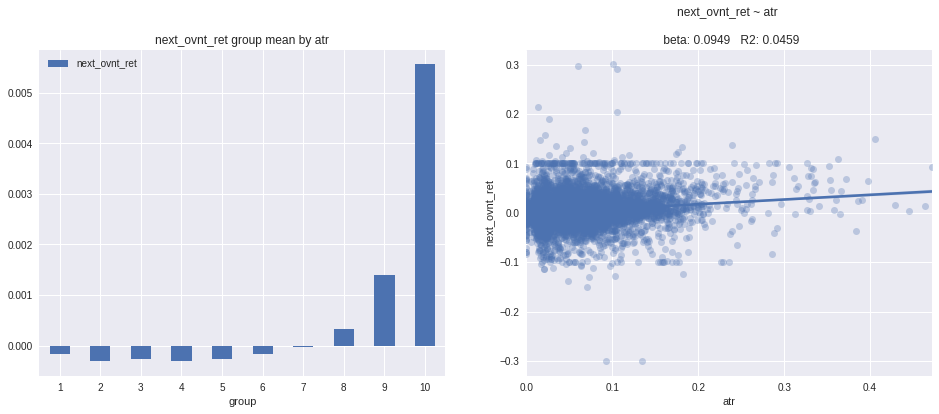

In [29]:
linearAnalysis(cbond_data, 'atr', 'next_ovnt_ret')

In [30]:
cbond_data['ovnt_fac'] = cbond_data['abs_intra_ret5'] + cbond_data['spread60']
cbond_data['ovnt_fac2'] = cbond_data['atr'] + cbond_data['spread60']

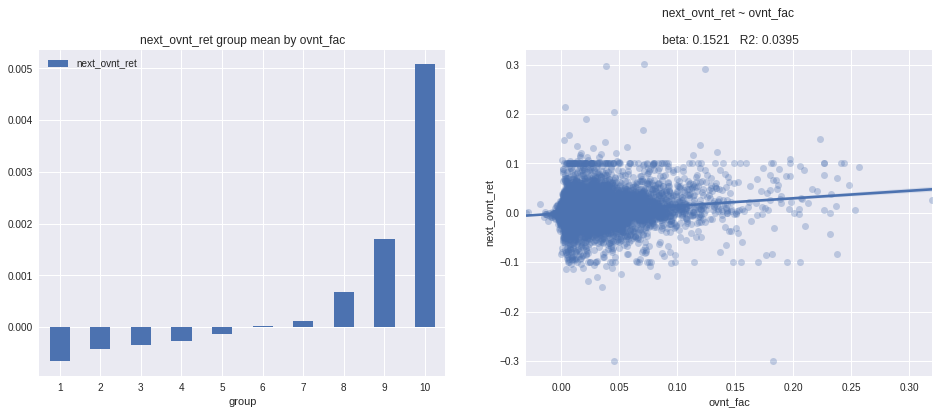

In [31]:
linearAnalysis(cbond_data, 'ovnt_fac', 'next_ovnt_ret')

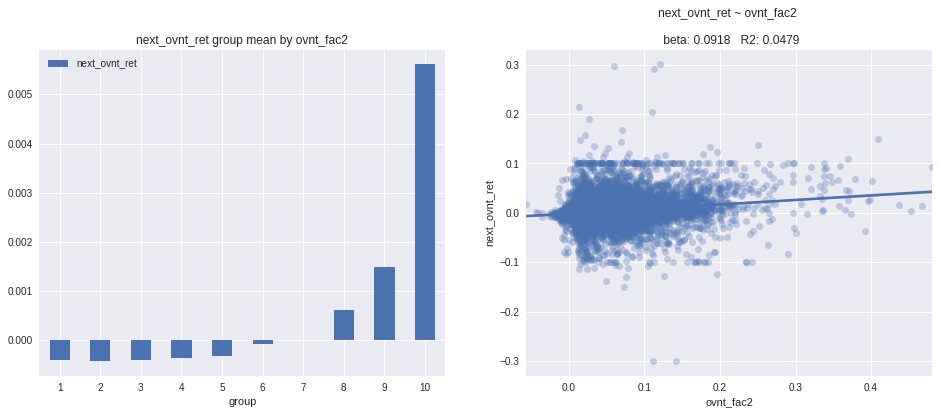

In [32]:
linearAnalysis(cbond_data, 'ovnt_fac2', 'next_ovnt_ret')

In [33]:
# save ovnt data to csv
ovnt_arb = cbond_data[['date', 'bond_ticker', 'stock_ticker', 'score', 'ovnt_fac', 'ovnt_fac2', 'up', 
                       'top1500', 'CSI300', 'CSI800']].copy()
ovnt_arb.to_csv(os.path.join(data_path, 'ovnt_arb.csv'), index=False)

#### ML model data

In [34]:
cbond_data.columns

Index(['date', 'bond_ticker', 'stock_ticker', 'high', 'low', 'open', 'close',
       'volume', 'ovnt_ret', 'intra_ret', 'return', 'premium_open',
       'premium_close', 'neg_premium', 'amount', 'value', 'mkt', 'bond_weight',
       'stock_weight', 'stock_ovnt_ret', 'stock_intra_ret', 'stock_ret',
       'is_last', 'top1500', 'CSI300', 'CSI800', 'ret', 'abs_ret',
       'abs_ovnt_ret', 'abs_intra_ret', 'abs_stock_ret', 'next_ret',
       'next_ovnt_ret', 'next_intra_ret', 'up', 'up_bool', 'datetime', 'year',
       'atr', 'score', 'ovnt_ret3', 'ret3', 'abs_ret3', 'abs_intra_ret3',
       'stock_ovnt_ret3', 'premium_close3', 'premium_open3', 'spread3',
       'ovnt_ret5', 'ret5', 'abs_ret5', 'abs_intra_ret5', 'stock_ovnt_ret5',
       'premium_close5', 'premium_open5', 'spread5', 'ovnt_ret10', 'ret10',
       'abs_ret10', 'abs_intra_ret10', 'stock_ovnt_ret10', 'premium_close10',
       'premium_open10', 'spread10', 'ovnt_ret30', 'ret30', 'abs_ret30',
       'abs_intra_ret30', 'stock_ovn

In [35]:
# create model data for machine learning algo
ml_model_data = cbond_data.drop(columns=['high', 'low', 'open', 'close','volume', 'amount', 'value', 'mkt',
                                          'return', 'next_ret', 'next_intra_ret', 'datetime', 'year', 'is_last',
                                         'score', 'ovnt_fac', 'ovnt_fac2', 'atr'])
ml_model_data = ml_model_data.sort_values(by=['date', 'bond_ticker']).reset_index(drop=True)
ml_model_data.head()

,date,bond_ticker,stock_ticker,ovnt_ret,intra_ret,premium_open,premium_close,neg_premium,bond_weight,stock_weight,stock_ovnt_ret,stock_intra_ret,stock_ret,top1500,CSI300,CSI800,ret,abs_ret,abs_ovnt_ret,abs_intra_ret,abs_stock_ret,next_ovnt_ret,up,up_bool,ovnt_ret3,ret3,abs_ret3,abs_intra_ret3,stock_ovnt_ret3,premium_close3,premium_open3,spread3,ovnt_ret5,ret5,abs_ret5,abs_intra_ret5,stock_ovnt_ret5,premium_close5,premium_open5,spread5,ovnt_ret10,ret10,abs_ret10,abs_intra_ret10,stock_ovnt_ret10,premium_close10,premium_open10,spread10,ovnt_ret30,ret30,abs_ret30,abs_intra_ret30,stock_ovnt_ret30,premium_close30,premium_open30,spread30,ovnt_ret60,ret60,abs_ret60,abs_intra_ret60,stock_ovnt_ret60,premium_close60,premium_open60,spread60
0,20170104,110030.SH,600185.SH,-0.0004,0.0020,0.4172,0.4032,False,0.0065,0.0195,-0.0017,0.0120,0.0103,False,False,False,0.0017,0.0017,0.0004,0.0020,0.0103,0.0052,0,False,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0000,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0000
1,20170104,110031.SH,600271.SH,0.0027,-0.0016,1.2868,1.2911,False,0.1101,0.1049,0.0020,-0.0034,-0.0015,False,True,True,0.0011,0.0011,0.0027,0.0016,0.0015,0.0002,0,False,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0021,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022,0.0027,0.0011,0.0011,0.0016,0.0020,1.2911,1.2868,0.0022
2,20170104,110032.SH,600031.SH,-0.0018,0.0038,0.3356,0.3257,False,0.1056,0.0771,-0.0016,0.0112,0.0096,False,True,True,0.0020,0.0020,0.0018,0.0038,0.0096,0.0000,0,False,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014,-0.0018,0.0020,0.0020,0.0038,-0.0016,0.3257,0.3356,-0.0014
3,20170104,110033.SH,600755.SH,0.0000,0.0074,0.2274,0.2233,False,0.0528,0.1409,0.0000,0.0107,0.0107,True,False,True,0.0074,0.0074,0.0000,0.0074,0.0107,-0.0034,0,False,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000,0.0000,0.0074,0.0074,0.0074,0.0000,0.2233,0.2274,0.0000
4,20170104,110034.SH,600998.SH,-0.0002,0.0123,0.0855,0.1109,False,0.0425,0.0399,0.0047,-0.0108,-0.0062,False,False,False,0.0121,0.0121,0.0002,0.0123,0.0062,0.0075,0,False,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0014,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0014,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0013,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0012,-0.0002,0.0121,0.0121,0.0123,0.0047,0.1109,0.0855,-0.0012


In [36]:
# save ml model data to csv
ml_model_data.to_csv(os.path.join(data_path, 'ml_model_data.csv'), index=False)

### 4. pricing model

In [37]:
# load pricing model data
price_model_path = os.path.join(data_path, 'model_V3')
models = os.listdir(price_model_path)

price_model_data = []

for model in models:
    price_model_data.append(pd.read_csv(os.path.join(price_model_path, model), index_col=False, low_memory=False))
    
price_model_data = pd.concat(price_model_data)
price_model_data = price_model_data.sort_values(by=['bond_ticker', 'date']).reset_index(drop=True)
price_model_data['overvalue'] = price_model_data['close'] / price_model_data['model'] - 1

price_model_data.head()

,date,bond_ticker,stock_ticker,vol,close,model,overvalue
0,20170103,110030.SH,600185.SH,0.5442,114.0400,114.7751,-0.0064
1,20170104,110030.SH,600185.SH,0.5393,114.2300,110.1316,0.0372
2,20170105,110030.SH,600185.SH,0.5258,114.9500,113.9838,0.0085
3,20170106,110030.SH,600185.SH,0.5208,114.8600,114.1824,0.0059
4,20170109,110030.SH,600185.SH,0.5880,115.5300,112.4799,0.0271


In [38]:
# feature engineering
def validCount(series):
    """
    return valid status of given series(invalid if consecutive extreme overvalue detected)
    """
    series = list(series)
    count = []
    for i, s in enumerate(series):
        if s == 0:
            if i != 0:
                count.append(max(0, count[i-1] - 1))
            else:
                count.append(0)
        else:
            if i != 0:
                count.append(count[i-1] + 1)
            else:
                count.append(1)
    return count

price_model_data['abs_overvalue'] = price_model_data['overvalue'].abs()

groups = []
for tkr, group in price_model_data.groupby('bond_ticker'):
    count = validCount(group['abs_overvalue'] >= 0.3)
    group = group.reset_index(drop=True)
    valid = np.array([True] * len(group))
    invalid_idx = np.where(np.array(count) >= 2)
    if len(invalid_idx[0]) > 0:
        valid[max(0, invalid_idx[0][0] - 1):] = False
    group['valid'] = valid
    groups.append(group)
    
model_data = pd.concat(groups).reset_index(drop=True)
model_data.head()

,date,bond_ticker,stock_ticker,vol,close,model,overvalue,abs_overvalue,valid
0,20170103,110030.SH,600185.SH,0.5442,114.0400,114.7751,-0.0064,0.0064,True
1,20170104,110030.SH,600185.SH,0.5393,114.2300,110.1316,0.0372,0.0372,True
2,20170105,110030.SH,600185.SH,0.5258,114.9500,113.9838,0.0085,0.0085,True
3,20170106,110030.SH,600185.SH,0.5208,114.8600,114.1824,0.0059,0.0059,True
4,20170109,110030.SH,600185.SH,0.5880,115.5300,112.4799,0.0271,0.0271,True


In [39]:
# feature engineering
model_data['date'] = model_data['date'].astype('str')
model_data = pd.merge(right=cbond_data, 
                      left=model_data[['date', 'bond_ticker', 'stock_ticker', 'model', 'valid']], 
                      on=['date', 'bond_ticker', 'stock_ticker'], how='inner')

model_data['overvalue'] = model_data['close'] / model_data['model'] - 1
model_data['cum_ov'] = model_data.groupby('bond_ticker')['overvalue'].cumsum()
model_data['abs_cum_ov'] = model_data['cum_ov'].abs()

model_data['mom_ov'] = model_data.groupby('bond_ticker')['cum_ov'].apply(talib.ROCR, timeperiod=1) - 1
model_data['mom_ov5'] = model_data.groupby('bond_ticker')['cum_ov'].apply(talib.ROCR, timeperiod=5) - 1

model_data['hedge_ret'] = model_data['ret'] - model_data['stock_ret']
model_data['hedge_intra_ret'] = model_data['intra_ret'] - model_data['stock_intra_ret']
model_data['hedge_ovnt_ret'] = model_data['ovnt_ret'] - model_data['stock_ovnt_ret']

model_data['next_hedge_ret'] = model_data.groupby('bond_ticker')['hedge_ret'].shift(-1)
model_data['next_hedge_intra_ret'] = model_data.groupby('bond_ticker')['hedge_intra_ret'].shift(-1)
model_data['next_hedge_ovnt_ret'] = model_data.groupby('bond_ticker')['hedge_ovnt_ret'].shift(-1)

wins = [5, 10, 30, 50, 100]
for win in wins:
    model_data['next_ret{}'.format(win)] = model_data.groupby('bond_ticker').apply(
        lambda g: g['next_ret'].rolling(win, min_periods=1).mean().shift(-win)).values
    model_data['intra_ret{}'.format(win)] = cbond_data.groupby('bond_ticker').apply(
        lambda g: g['intra_ret'].rolling(win, min_periods=1).mean()).values
    
model_data.head()

,date,bond_ticker,stock_ticker,model,valid,high,low,open,close,volume,ovnt_ret,intra_ret,return,premium_open,premium_close,neg_premium,amount,value,mkt,bond_weight,stock_weight,stock_ovnt_ret,stock_intra_ret,stock_ret,is_last,top1500,CSI300,CSI800,ret,abs_ret,abs_ovnt_ret,abs_intra_ret,abs_stock_ret,next_ret,next_ovnt_ret,next_intra_ret,up,up_bool,datetime,year,atr,score,ovnt_ret3,ret3,abs_ret3,abs_intra_ret3,stock_ovnt_ret3,premium_close3,premium_open3,spread3,ovnt_ret5,ret5,abs_ret5,abs_intra_ret5,stock_ovnt_ret5,premium_close5,premium_open5,spread5,ovnt_ret10,ret10,abs_ret10,abs_intra_ret10,stock_ovnt_ret10,premium_close10,premium_open10,spread10,ovnt_ret30,ret30,abs_ret30,abs_intra_ret30,stock_ovnt_ret30,premium_close30,premium_open30,spread30,ovnt_ret60,ret60,abs_ret60,abs_intra_ret60,stock_ovnt_ret60,premium_close60,premium_open60,spread60,ovnt_fac,ovnt_fac2,overvalue,cum_ov,abs_cum_ov,mom_ov,mom_ov5,hedge_ret,hedge_intra_ret,hedge_ovnt_ret,next_hedge_ret,next_hedge_intra_ret,next_hedge_ovnt_ret,next_ret5,intra_ret5,next_ret10,intra_ret10,next_ret30,intra_ret30,next_ret50,intra_ret50,next_ret100,intra_ret100
0,20170104,110030.SH,600185.SH,110.1316,True,114.3500,113.9500,114.0000,114.2300,1201.0000,-0.0004,0.0020,0.0017,0.4172,0.4032,False,0.0137,0.3096,121.2310,0.0065,0.0195,-0.0017,0.0120,0.0103,False,False,False,False,0.0017,0.0017,0.0004,0.0020,0.0103,0.0063,0.0052,0.0011,0,False,2017-01-04,2017,0.0000,0.0017,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0001,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0000,-0.0004,0.0017,0.0017,0.0020,-0.0017,0.4032,0.4172,0.0000,0.0020,0.0000,0.0372,0.0372,0.0372,NaN,NaN,-0.0086,-0.0100,0.0014,-0.0005,0.0241,-0.0253,-0.0002,0.0020,-0.0019,0.0020,-0.0007,0.0020,-0.0012,0.0020,-0.0001,0.0020
1,20170105,110030.SH,600185.SH,113.9838,True,115.5000,114.3600,114.8200,114.9500,9999.0000,0.0052,0.0011,0.0063,0.3688,0.4026,False,0.1152,0.5564,123.9090,0.0287,0.0325,0.0305,-0.0230,0.0068,False,False,False,False,0.0063,0.0063,0.0052,0.0011,0.0068,-0.0008,-0.0030,0.0023,0,False,2017-01-05,2017,0.0000,0.0063,0.0024,0.0040,0.0040,0.0016,0.0144,0.4029,0.3930,-0.0014,0.0024,0.0040,0.0040,0.0016,0.0144,0.4029,0.3930,-0.0013,0.0024,0.0040,0.0040,0.0016,0.0144,0.4029,0.3930,-0.0012,0.0024,0.0040,0.0040,0.0016,0.0144,0.4029,0.3930,-0.0009,0.0024,0.0040,0.0040,0.0016,0.0144,0.4029,0.3930,-0.0008,0.0008,-0.0008,0.0085,0.0457,0.0457,0.2278,NaN,-0.0005,0.0241,-0.0253,0.0076,0.0090,-0.0014,0.0000,0.0016,-0.0016,0.0016,-0.0006,0.0016,-0.0012,0.0016,-0.0001,0.0016
2,20170106,110030.SH,600185.SH,114.1824,True,115.1500,114.6000,114.6000,114.8600,4822.0000,-0.0030,0.0023,-0.0008,0.4007,0.4134,False,0.0554,0.2191,122.0550,0.0334,0.0170,-0.0017,-0.0067,-0.0084,False,False,False,False,-0.0008,0.0008,0.0030,0.0023,0.0084,0.0058,0.0000,0.0058,0,False,2017-01-06,2017,0.0000,-0.0008,0.0006,0.0024,0.0029,0.0018,0.0090,0.4064,0.3955,-0.0018,0.0006,0.0024,0.0029,0.0018,0.0090,0.4064,0.3955,-0.0018,0.0006,0.0024,0.0029,0.0018,0.0090,0.4064,0.3955,-0.0017,0.0006,0.0024,0.0029,0.0018,0.0090,0.4064,0.3955,-0.0015,0.0006,0.0024,0.0029,0.0018,0.0090,0.4064,0.3955,-0.0014,0.0004,-0.0014,0.0059,0.0516,0.0516,0.1299,NaN,0.0076,0.0090,-0.0014,0.0092,0.0075,0.0017,-0.0046,0.0018,-0.0022,0.0018,-0.0008,0.0018,-0.0013,0.0018,-0.0001,0.0018
3,20170109,110030.SH,600185.SH,112.4799,True,115.5300,114.3000,114.8600,115.5300,3337.0000,0.0000,0.0058,0.0058,0.4158,0.4264,False,0.0383,0.3664,121.2310,0.0127,0.0189,-0.0017,-0.0017,-0.0034,False,False,False,False,0.0058,0.0058,0.0000,0.0058,0.0034,-0.0033,0.0028,-0.0060,0,False,2017-01-09,2017,0.0000,0.0058,0.0007,0.0038,0.0043,0.0031,0.0090,0.4141,0.3951,-0.0017,0.0004,0.0033,0.0036,0.0028,0.0063,0.4114,0.4006,-0.0012,0.0004,0.0033,0.0036,0.0028,0.0063,0.4114,0.4006,-0.0011,0.0004,0.0033,0.0036,0.0028,0.0063,0.4114,0.4006,-0.0010,0.0004,0.0033,0.0036,0.0028,0.0063,0

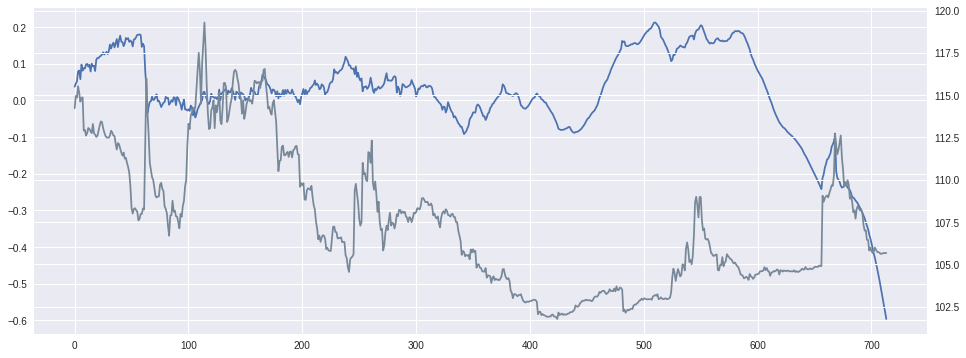

In [40]:
# sample cum_ov & close ploting
bond_tickers = model_data['bond_ticker'].unique().tolist()
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
model_data.loc[model_data['bond_ticker']==bond_tickers[0], 'cum_ov'].plot(ax=ax1)
ax_twin = ax1.twinx()
model_data.loc[model_data['bond_ticker']==bond_tickers[0], 'close'].plot(ax=ax_twin, c='lightslategrey')
fig.show()

In [41]:
model_data[['intra_ret', 'stock_intra_ret', 'hedge_intra_ret',
            'ovnt_ret', 'stock_ovnt_ret', 'hedge_ovnt_ret']].describe()

,intra_ret,stock_intra_ret,hedge_intra_ret,ovnt_ret,stock_ovnt_ret,hedge_ovnt_ret
count,97161.0000,97161.0000,97161.0000,97161.0000,97161.0000,97161.0000
mean,0.0003,0.0015,-0.0012,0.0006,-0.0007,0.0013
std,0.0201,0.0252,0.0213,0.0102,0.0140,0.0122
min,-0.3293,-0.1775,-0.2893,-0.3000,-0.1694,-0.3016
25%,-0.0052,-0.0119,-0.0106,-0.0017,-0.0047,-0.0039
50%,0.0001,0.0000,-0.0005,0.0000,0.0000,0.0001
75%,0.0056,0.0131,0.0091,0.0017,0.0038,0.0052
max,0.7773,0.2042,0.7773,0.3004,0.1014,0.2682


The difference of intraday and overnight return between convertible bond and stock market is large (both inner and outer)

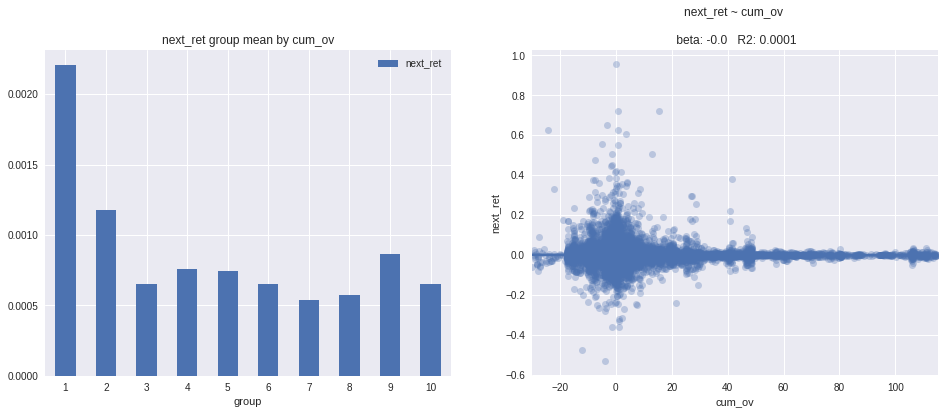

In [42]:
linearAnalysis(model_data, 'cum_ov', 'next_ret', group_num=10)

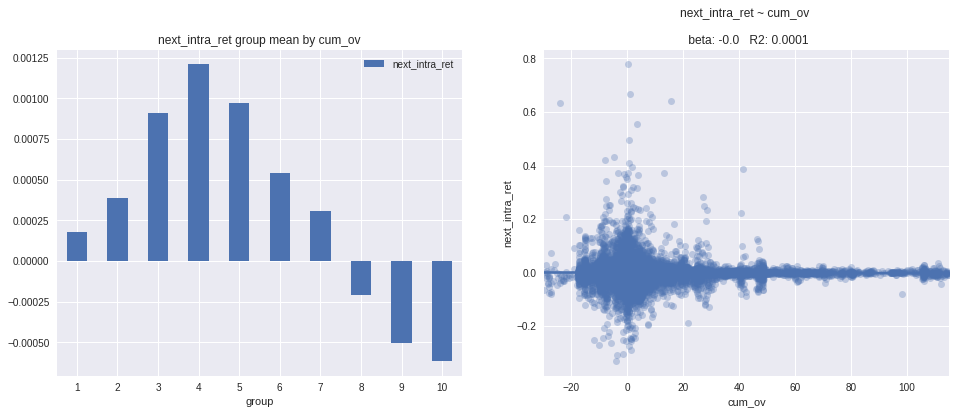

In [43]:
linearAnalysis(model_data, 'cum_ov', 'next_intra_ret', group_num=10)

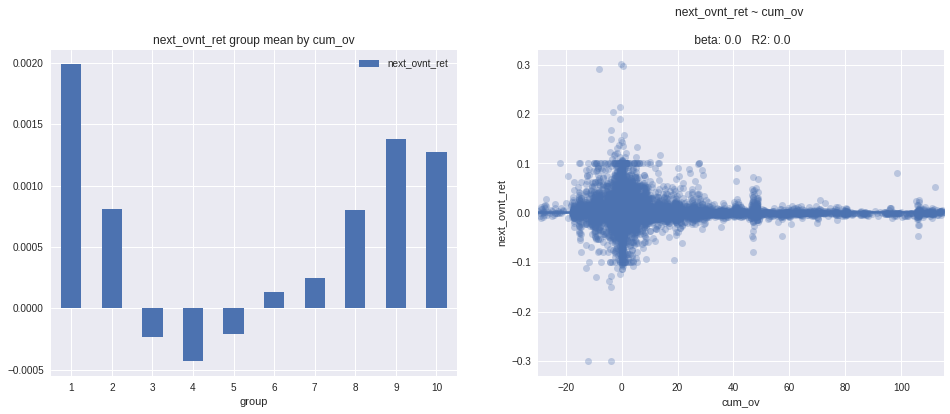

In [44]:
linearAnalysis(model_data, 'cum_ov', 'next_ovnt_ret', group_num=10)

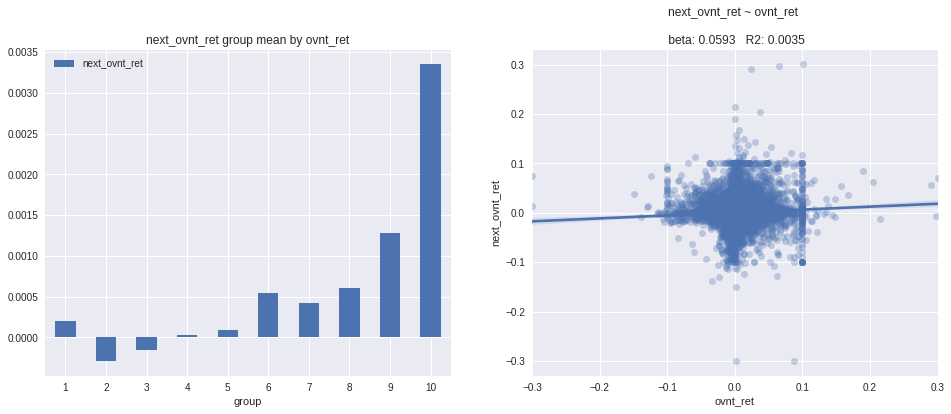

In [45]:
linearAnalysis(model_data, 'ovnt_ret', 'next_ovnt_ret', group_num=10)

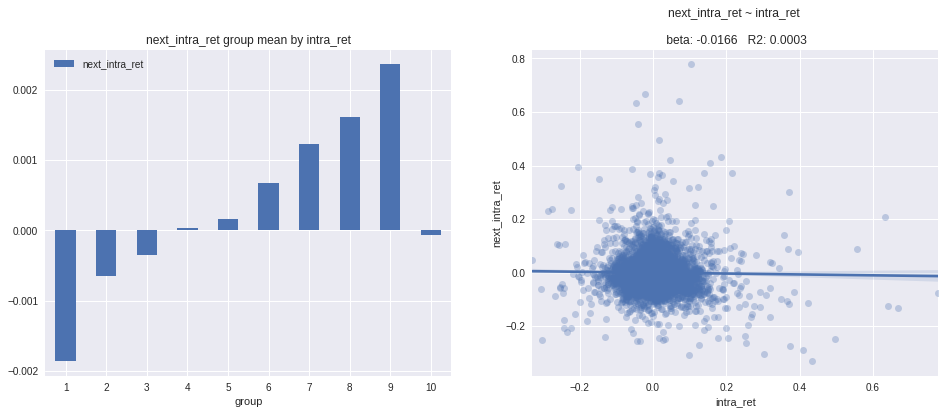

In [46]:
linearAnalysis(model_data, 'intra_ret', 'next_intra_ret', group_num=10)

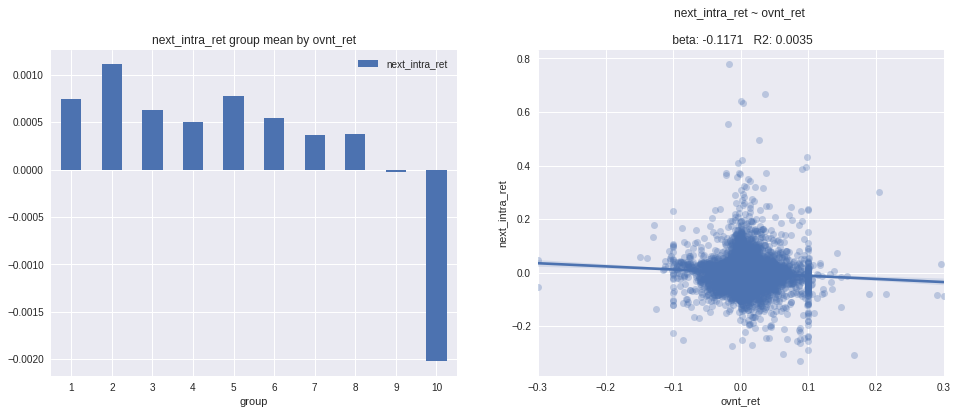

In [47]:
linearAnalysis(model_data, 'ovnt_ret', 'next_intra_ret', group_num=10)

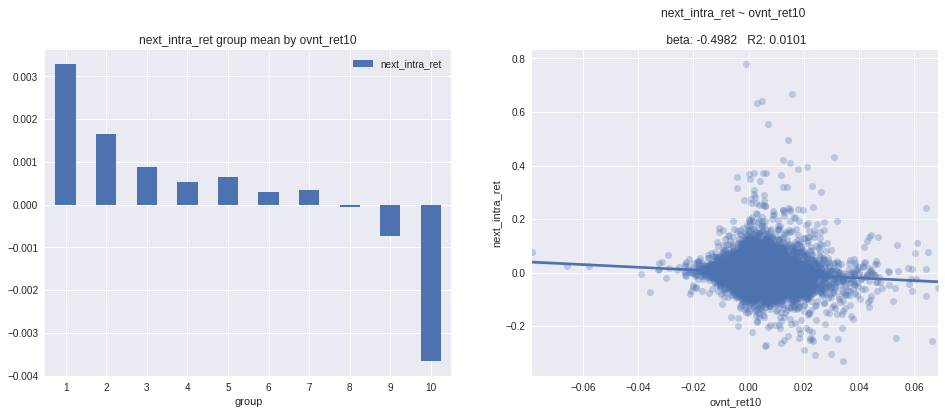

In [48]:
linearAnalysis(model_data, 'ovnt_ret10', 'next_intra_ret', group_num=10)

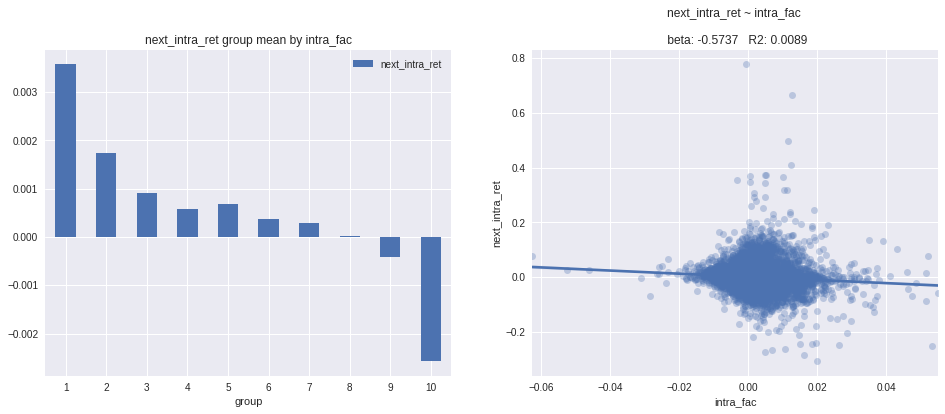

In [49]:
alpha = 0.8
model_data['intra_fac'] = model_data['ovnt_ret10'] * alpha +\
                          model_data['abs_cum_ov'].fillna(0) * (1 - alpha) / 1000
linearAnalysis(model_data[model_data['valid']==True], 'intra_fac', 'next_intra_ret', group_num=10)

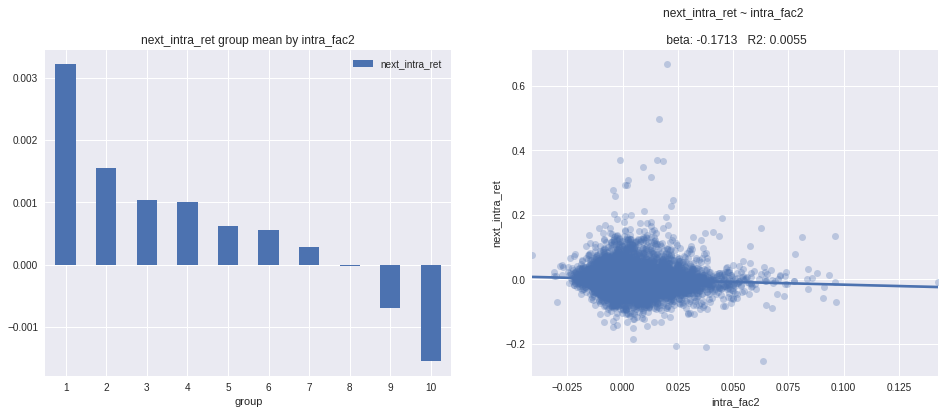

In [50]:
model_data['intra_fac2'] = model_data['ovnt_ret10'] - model_data['intra_ret10']
linearAnalysis(model_data[(model_data['intra_ret10'] <= 0.01) & 
                          (model_data['valid']==True)], 'intra_fac2', 'next_intra_ret', group_num=10)

In [51]:
# save pricing data & intra fac to csv
pricing_data = model_data[['date', 'bond_ticker', 'stock_ticker',  'intra_fac', 'intra_fac2', 'ovnt_fac', 'overvalue', 'cum_ov', 'intra_ret10', 'valid',
                       'top1500', 'CSI300', 'CSI800']].copy()
pricing_data.to_csv(os.path.join(data_path, 'pricing.csv'), index=False)